In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import json, pandas as pd, glob, tqdm
import gzip

def label(line, label, idx=-1, dx=0, **kwargs):
    if isinstance(line, list): line = line[0]
    x, y = line.get_data()
    plt.text(
        x[idx]+dx,
        y[idx],
        label,
        **kwargs, color=line.get_color())
    

plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.family'] = 'Noto sans'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.directory'] = '.'
plt.rcParams['font.size'] = 16
import jax
import jax.numpy as jnp


def spatial_to_delay(r, from_=None):
    if from_ is not None:
        d = jax.vmap(lambda ri: jnp.sqrt(1e-2+((from_ - ri)**2).sum(axis=1)))(r)
        # d.shape is here (r.shape[0], from_.shape[0])
        d = d.flatten()
        return d
    else:
        d = jax.vmap(lambda ri: jnp.sqrt(1e-2+((r - ri)**2).sum(axis=1)))(r)
        d = diagonal_const(d, 1000000)
        d = d.flatten()
        return d
    
    

def diagonal_const(arr, c):
    n = arr.shape[0]
    return arr * (1 - jnp.eye(n)) + jnp.eye(n) * c

# One

In [3]:
glob.glob?

Signature: glob.glob(pathname, *, root_dir=None, dir_fd=None, recursive=False)
Docstring:
Return a list of paths matching a pathname pattern.

The pattern may contain simple shell-style wildcards a la
fnmatch. However, unlike fnmatch, filenames starting with a
dot are special cases that are not matched by '*' and '?'
patterns.

If recursive is true, the pattern '**' will match any files and
zero or more directories and subdirectories.
File:      /usr/lib/python3.10/glob.py
Type:      function


In [4]:
!pwd

tables = {}

for f in tqdm.tqdm(glob.glob('saved/*/log.jsons*')):
    args, hparams = {}, {}
    handle = gzip.open(f, 'rt') if f.endswith('.gz') else open(f)
    try:
        with handle as fh:
            for l in fh:
                j = json.loads(l)
                t = j.pop('table')
                if t == 'args': args = j
                elif t == 'hyperparams': hparams = j
                elif t in {'epoch', 'sparse_epoch'}:
                    j.update(args)
                    j.update(hparams)
                    tables.setdefault(t, []).append(j)
    except Exception as ex:
        print()
        print(repr(ex))
        print(f)
        print()

dfs = {t: pd.DataFrame(v) for t, v in tables.items()}
epoch = dfs['epoch']


epoch['plotdim'] = epoch.apply(lambda x:
                               6 if x.netspec == 'inf' else x['ndim'], 1)

final = epoch[(epoch.i == 29) & (epoch.dt == 0.5)]
final = final[final.tgtfreq == 10]

/home/llandsmeer/repos/llandsmeer/spatial_delays


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1360/1360 [00:24<00:00, 54.73it/s]


In [19]:

finalnormal
#bool( float('nan'))

,id,i,t1p,t3p,t1p_train,t3p_train,net,nhidden,batch_size,load_limit,...,tgtfreq,population_freq,tag,ninput,noutput,netspec,ndim,line,sparse,plotdim
79,16232b66-4a1a-4ede-8abf-0c201c18d973,29,68.200233,88.469330,96.679688,99.804688,0,70,32,None,...,10.0,NaN,NaN,700,20,0,0.0,NaN,NaN,0.0
169,4944759d-6e0e-46f0-a5fd-a6033b4eb407,29,78.501160,91.739006,97.851562,100.000000,3,150,32,None,...,10.0,NaN,NaN,700,20,3,3.0,NaN,NaN,3.0
229,bfa2ad90-fb52-4540-a926-0414f2b37da4,29,73.133682,91.869217,96.243988,99.804688,0,300,32,None,...,10.0,NaN,NaN,700,20,0,0.0,NaN,NaN,0.0
459,049de944-3df6-4a48-8afb-cf99b772f38d,29,73.336227,91.507523,94.591347,99.609375,2,30,32,None,...,10.0,False,default,700,20,2,2.0,NaN,NaN,2.0
489,c154b61f-a78f-4646-a0f5-9febfc8201a7,29,70.355904,91.348381,98.197113,100.000000,inf,70,32,None,...,10.0,NaN,NaN,700,20,inf,inf,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39178,0e24709e-5ab4-4297-96fa-9cfb1cec9af9,29,74.160881,92.230904,97.851562,100.000000,inf,50,32,None,...,10.0,NaN,NaN,700,20,inf,inf,NaN,NaN,6.0
39288,0868f9f0-dc4a-4e45-8710-441c50a72397,29,63.917828,88.006371,77.674278,93.569710,3,10,32,None,...,10.0,NaN,NaN,700,20,3,3.0,NaN,NaN,3.0
39318,e6d3fd1f-4d6d-489a-ba25-ba834738f30c,29,63.657410,87.731483,78.846153,94.936897,2,10,32,None,...,10.0,False,default,700,20,2,2.0,NaN,NaN,2.0
39408,da2f233b-f9bd-4d48-894e-457da394e357,29,71.585648,91.652199,98.437500,100.000000,0,100,32,None,...,10.0,NaN,NaN,700,20,0,0.0,NaN,NaN,0.0


0
∞
2
3


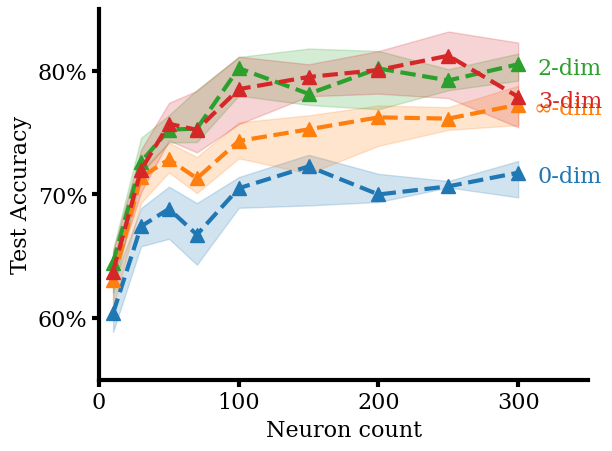

In [20]:
take = [
    '0', 'inf', '2', '3'
    ]

finalnormal = final[(final.net.isin(take)) & (True != final['sparse']) & (final.tgtfreq==10) & (final.population_freq != True) & (line != True)]

finalnormal

ERR = False



plt.xlabel('Neuron count')
if ERR:
    plt.ylim([0, 50])
    plt.ylabel('Test Error')
else:
    plt.ylabel('Test Accuracy')
    plt.ylim([55, 85])
    plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])
plt.xticks([0, 100, 200, 300])
plt.xlim([0, 350])




# for net, sub in finalnormal.groupby('netspec'):
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25)
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75)
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    y = sub.t1p
    if ERR: y = 100 - y
    color = None
    # if net == '0': color = 'black'
    # elif net == 'inf': color = 'blue'
    line,  = plt.plot(sub.index, y, '^--', label=net, color=color)
    plt.fill_between(sub.index, low.t1p, high.t1p, color=line.get_color(), alpha=0.2)
    net = net.replace('inf', '∞')
    plt.text(
        sub.index.values[-1]+60,
        y.values[-1] - 0.3,
        f'{net}-dim',
        va='center',
        ha='right',
        color=line.get_color()
    )
    print(net)
    plt.tight_layout()
    plt.savefig(f'img/{net}-dim.svg')
    plt.savefig(f'img/{net}-dim.png', dpi=300)

#plt.legend(title='Network Dimensions', ncol=2)
plt.show()

In [464]:
take = [
    '0', 'inf', '2', '3'
    ]

finalnormal = final[final.net.isin(take)]

finalnormal

ERR = False



plt.xlabel('Neuron count')
if ERR:
    plt.ylim([0, 50])
    plt.ylabel('Test Error')
else:
    plt.ylabel('Test Accuracy')
    plt.ylim([55, 85])
    plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])
plt.xticks([0, 100, 200, 300])
plt.xlim([0, 350])




# for net, sub in finalnormal.groupby('netspec'):
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25)
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75)
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    y = sub.t1p
    if ERR: y = 100 - y
    color = None
    # if net == '0': color = 'black'
    # elif net == 'inf': color = 'blue'
    line,  = plt.plot(sub.index, y, '^--', label=net, color=color)
    net = net.replace('inf', '∞')
    plt.text(
        sub.index.values[-1]+60,
        y.values[-1] - 0.3,
        f'{net}-dim',
        va='center',
        ha='right',
        color=line.get_color()
    )
    print(net)
    
plt.tight_layout()
plt.savefig(f'img/nofill-dim.svg')
plt.savefig(f'img/nofill-dim.png', dpi=300)

0
∞
2
3


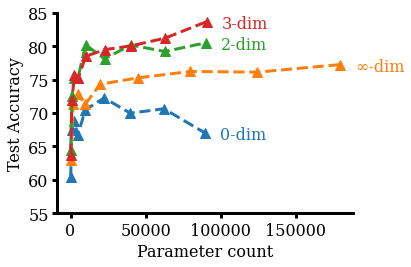

In [473]:
take = [
    '0', 'inf', '2', '3'
    ]

finalnormal = final[final.net.isin(take)]

finalnormal


plt.xlabel('Parameter count')
plt.ylabel('Test Accuracy')
plt.ylim([55, 85])
# plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])
# plt.xticks([0, 100, 200, 300])
# plt.xlim([0, 350])




# for net, sub in finalnormal.groupby('netspec'):
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25)
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75)
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    y = sub.t1p
    color = None
    # if net == '0': color = 'black'
    # elif net == 'inf': color = 'blue'
    neurons = sub.index.values
    if net == '0':
        params = neurons * (neurons - 1)
    elif net == 'inf':
        params = 2 * neurons * (neurons - 1)
    else:
        params = neurons * (neurons - 1) + neurons * int(net)
    line,  = plt.plot(params, y, '^--', label=net, color=color)
    net = net.replace('inf', '∞')
    plt.text(
        params[-1]+10000,
        y.values[-1] - 0.3,
        f'{net}-dim',
        va='center',
        ha='left',
        color=line.get_color()
    )
    print(net)
    
plt.tight_layout()
plt.savefig(f'img/nofill-params-dim.svg')
plt.savefig(f'img/nofill-params-dim.png', dpi=300)

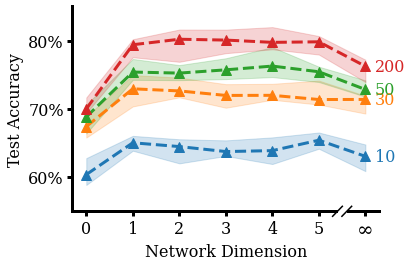

In [450]:
import matplotlib.transforms as mtrans

take = [
    '0', '1', '2', '3', '4', '5', 'inf'
    ]
ax = plt.gca()

finalnormal = final[final.net.isin(take)]

take_nh = [ 10, 30, 50, 200 ]

plt.ylabel('Test Accuracy')
plt.ylim([55, 85])
plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])

ticks = [0, 1, 2, 3, 4, 5, 6]
labels = [0, 1, 2, 3, 4, 5, '∞']
ax.set_xticks(ticks)
text_labels = ax.set_xticklabels(labels)

text_labels[-1].set_fontsize(20)

for nh, sub in finalnormal.groupby('nhidden'):
    if take_nh and nh not in take_nh: continue
    sub = sub.sort_values('plotdim')
    low = sub[['plotdim', 't1p']].groupby('plotdim').quantile(0.25)
    high = sub[['plotdim', 't1p']].groupby('plotdim').quantile(0.75)
    sub = sub[['plotdim', 't1p']].groupby('plotdim').median()
    line,  = plt.plot(sub.index, sub.t1p, '^--')
    plt.fill_between(sub.index, low.t1p, high.t1p, color=line.get_color(), alpha=0.2)
    plt.text(
        sub.index.values[-1]+0.2,
        sub.t1p.values[-1],
        f'{nh}',
        va='center',
        ha='left',
        color = line.get_color()
    )

plt.gcf().canvas.draw()
x_positions = [5.4, 5.6]
y_data = ax.get_ylim()[0]
L_px = 15.0
half = L_px / 2.0
d = half / np.sqrt(2.0)
to_display = ax.transData.transform
to_data = ax.transData.inverted().transform
to_display = ax.transData.transform
to_data = ax.transData.inverted().transform
ax.plot([min(x_positions)+0.03, -0.03+max(x_positions)], [y_data, y_data], color='w', linewidth=3, clip_on=False, zorder=10)
for x0 in x_positions:
    x_disp, y_disp = to_display((x0, y_data))
    p1_disp = (x_disp - d, y_disp - d)
    p2_disp = (x_disp + d, y_disp + d)
    p1_data = to_data(p1_disp)
    p2_data = to_data(p2_disp)
    ax.plot([p1_data[0], p2_data[0]], [p1_data[1], p2_data[1]],
            color='k', linewidth=1.5, clip_on=False, zorder=100)
plt.xlabel('Network Dimension')
plt.tight_layout()
plt.savefig('img/netw.svg')
plt.savefig('img/netw.png')
plt.show()

# Eps

In [86]:
finaleps = (epoch[(epoch.i == 49) & (epoch.tag == 'fixed-eps')]).copy()

finaleps['eps'] = finaleps['netspec'].str.split('e').str[1].astype(float)
finaleps = finaleps.loc[:, finaleps.nunique() > 1]
finaleps = finaleps.drop('netspec', axis='columns').drop('net', axis='columns').drop('id', axis='columns')
# print(finaleps.groupby(['nhidden', 'plotdim', 'eps']).count())
low = finaleps.groupby(['nhidden', 'plotdim', 'eps']).quantile(0.5).reset_index().drop('seed', axis='columns')
high = finaleps.groupby(['nhidden', 'plotdim', 'eps']).quantile(0.75).reset_index().drop('seed', axis='columns')
finaleps = finaleps.groupby(['nhidden', 'plotdim', 'eps']).median().reset_index().drop('seed', axis='columns')
#finaleps = finaleps[finaleps.nhidden == 10].groupby('net').median().sort_values('netspec')

# 10, 30, 50
#for n in [10, 30, 50]:
for n in [10, 50]:
    X =finaleps[finaleps.nhidden == n]
    L =low[low.nhidden == n]
    H =high[high.nhidden == n]
    for d in [2, 3]:
        label(plt.plot(
            100+100*x[x.plotdim==d].eps,
            x[x.plotdim==d].t1p,
            '-'),
            f'{d}d, n={n}', dx=4)
        plt.fill_between(
            100+100*x[x.plotdim==d].eps.values,
            l[l.plotdim==d].t1p.values,
            h[h.plotdim==d].t1p.values, alpha=0.3, zorder=-100)

        
ml = np.array([100, 150, 200])
plt.xticks(ml, [f'{x}%' for x in ml])

#plt.legend()
plt.ylabel('Test accuracy')
plt.xlabel('Max length w.r.t. straight line')

plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])

plt.tight_layout()
#plt.savefig('img/eps.svg')
#plt.savefig('img/eps.png')


AttributeError: 'DataFrame' object has no attribute 'plotdim'

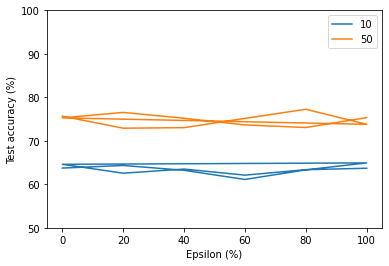

0.0
0.2
0.4
0.6
0.8
1.0


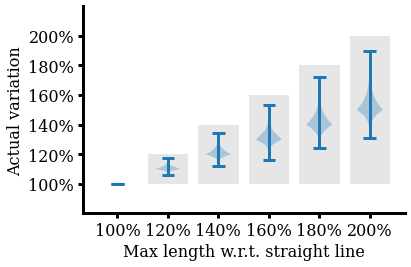

In [452]:
finaleps
finaleps = (epoch[(epoch.i == 49) & (epoch.tag == 'fixed-eps')]).copy()
finaleps['eps'] = finaleps['netspec'].str.split('e').str[1].astype(float)
finaleps = finaleps.loc[:, finaleps.nunique() > 1]

dd = dict()
for _idx, row in finaleps.iterrows():
    fns = glob.glob(f'saved/*{row.id}*/epoch_*049.npz')
    if not fns:
        continue
    if row.plotdim != 2:
        continue
    fn, = fns
    d = np.load(fn)
    ieps = 100 + 100 * row.eps * (0.5 + 0.5 * np.tanh(d['ierr']))
    reps = 100 + 100 * row.eps * (0.5 + 0.5 * np.tanh(d['rerr']))
    if row.eps not in dd:
        dd[row.eps] = []
    dd[row.eps].extend(reps)
    
plt.bar(
    np.arange(1, len(dd)+1),
    100*np.array(sorted(dd.keys())),
    bottom=100,
    color='0.9')

plt.violinplot(
    [dd[k] for k in sorted(dd.keys())]
);

for i, k in enumerate(sorted(dd.keys()), 1):
    print(k)

plt.xticks(np.arange(1, len(dd)+1), [f'{100+x*100:.0f}%' for x in sorted(dd.keys())])
# plt.yticks([100, 150, 200], ['100', '150%', '200%'])
plt.yticks([100+x*100 for x in sorted(dd.keys())],
           [f'{100+x*100:.0f}%' for x in sorted(dd.keys())])

#plt.xlabel('Epsilon')
plt.ylabel('Actual variation')
plt.xlabel('Max length w.r.t. straight line')

plt.ylim(80, 220)


#plt.

#trace = [
#    dict(np.load(x))
#    for x in 
#    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/saved/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
#        'saved/*3e1*/epoch_*.npz'
#    ) if not 'read' in x)
##]
plt.tight_layout()
plt.savefig('img/epsuse.svg')
plt.savefig('img/epsuse.png')

# Epsilon v2 

In [22]:
epoch[epoch.i == 49]

,id,i,t1p,t3p,t1p_train,t3p_train,net,nhidden,batch_size,load_limit,...,delaysigma,possigma,tgtfreq,ninput,noutput,netspec,ndim,population_freq,tag,plotdim
199,8b1ae5e3-0c4e-4620-a0a1-510a8435f0d7,49,58.420139,83.998840,79.582329,96.048676,2e0.60,10,32,None,...,1.0,20.0,10.0,700,20,2e0.60,2.0,False,fixed-eps,2.0
459,b9764e45-2a27-4d9a-bf72-fe9079d4ec9b,49,62.803822,87.254051,79.627403,94.681488,3e1.00,10,32,None,...,1.0,20.0,10.0,700,20,3e1.00,3.0,False,fixed-eps,3.0
651,b32d6be2-1eca-4b36-93af-031b1e1bd029,49,63.961231,87.847221,78.380409,95.898438,2e0.40,10,32,None,...,1.0,20.0,10.0,700,20,2e0.40,2.0,False,fixed-eps,2.0
1031,656fd55d-9e72-4c0e-b7a6-d29b55f4d82a,49,70.124428,91.059029,96.484375,99.023438,3e0.60,30,32,None,...,1.0,20.0,10.0,700,20,3e0.60,3.0,False,fixed-eps,3.0
1231,e1f48cd0-52f5-4658-869f-a2a93f41dbc6,49,73.654518,91.001160,96.003609,99.804688,3e1.00,50,32,None,...,1.0,20.0,10.0,700,20,3e1.00,3.0,False,fixed-eps,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24108,b06be5d3-14e7-4bfd-9477-9c1386b5289d,49,62.123840,86.805557,81.730766,96.003609,3e0.60,10,32,None,...,1.0,20.0,10.0,700,20,3e0.60,3.0,False,fixed-eps,3.0
24248,b94e229f-c5a4-4ee6-924f-cea611b1796e,49,65.104164,89.308449,84.014420,95.808296,3e0.00,10,32,None,...,1.0,20.0,10.0,700,20,3e0.00,3.0,False,fixed-eps,3.0
24358,7f9d718b-e34a-4728-a568-baa52cb3b40d,49,72.598381,92.925346,95.612984,99.759613,3e0.20,30,32,None,...,1.0,20.0,10.0,700,20,3e0.20,3.0,False,fixed-eps,3.0
24438,d19914d7-71ee-4909-bdf4-35ec6fce31c5,49,73.480904,92.491318,95.808296,99.609375,2e1.00,30,32,None,...,1.0,20.0,10.0,700,20,2e1.00,2.0,False,fixed-eps,2.0


In [23]:
# 

# Positions

In [356]:
# glob.glob('saved/*/epoch_00000000.npz')
df = epoch[
    (epoch['ndim']==2) &
    (epoch['i']==29)
].copy()

df['ntrace'] = df['id'].apply(lambda ident:  len(glob.glob(f'saved/*{ident}*/epoch_*.npz')) )

df = df[(df.ntrace > 10) & (df.netspec.apply(lambda x: 'e' not in x))]
df

,id,i,t1p,t3p,t1p_train,t3p_train,net,nhidden,batch_size,load_limit,...,possigma,tgtfreq,population_freq,tag,ninput,noutput,netspec,ndim,plotdim,ntrace
29,f0f9c26e-b745-46d9-8c4c-557912acf2c8,29,61.255787,86.892365,79.191704,95.853363,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
5905,a7a94219-e478-4aa7-adca-42bf1f9d5a32,29,65.046303,88.642937,81.911057,96.048676,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
10656,3302e3fc-86ad-4aca-a73a-db7daf882c58,29,65.842018,88.165504,79.627403,95.658051,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
10686,f0271c0f-43d3-4afa-97eb-a2c090efdcea,29,61.863422,86.979164,77.854568,95.853363,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
13503,cd766c3e-5c55-4d4d-a990-29dcce914294,29,63.700813,85.648148,78.665863,94.155647,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
14385,e27c9c06-d211-4bec-a88f-96af1634360c,29,68.359375,90.697342,78.350357,95.898438,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
15915,fe8405e5-0875-40c8-8f66-3c68bd728ac1,29,59.230328,84.982643,77.193512,95.072113,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
17714,8345f079-c669-48e7-80e2-0a17e9368a7c,29,61.168980,85.966438,79.627403,95.117188,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
20807,dda0997d-0e5f-42c2-9efa-1b69be69264d,29,66.637733,87.123840,81.971153,97.025238,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
22281,7b2d6415-d871-4bce-a771-32d1d87a70a9,29,58.405674,85.315399,79.236778,94.831734,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60


In [106]:
#'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_d57726df-ed90-4fa3-a28a-f9d6c8288b4c/epoch_00000000.npz'
ident = 'f0f9c26e-b745-46d9-8c4c-557912acf2c8'
trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/*{ident}*/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

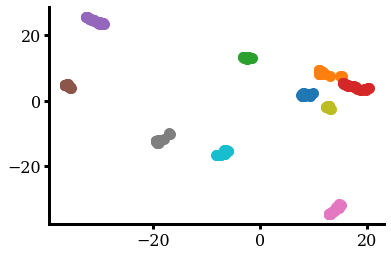

<Figure size 432x288 with 0 Axes>

In [358]:
for i in range(10):
    x = trace['ipos'][:,i,0]
    y = trace['ipos'][:,i,1]
    plt.plot(x, y, 'o--')
plt.figure()

In [359]:
# for i in range(10):
#     x = trace['ipos'][:,i,0] - trace['ipos'][0,i,0]
#     y = trace['ipos'][:,i,1] - trace['ipos'][0,i,1]
#     plt.plot(x, y, 'o--')

Text(0, 0.5, 'Weight')

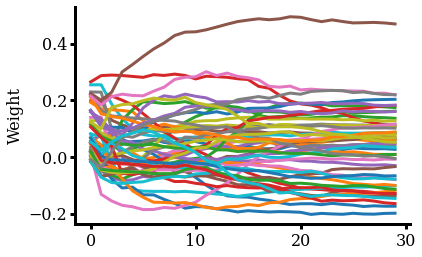

In [360]:
for i in range(10):
    plt.plot(trace['rw'][:,i,(i+1)%10])
    plt.plot(trace['rw'][:,i,(i+2)%10])
    plt.plot(trace['rw'][:,i,(i+3)%10])
    plt.plot(trace['rw'][:,i,(i+4)%10])
    plt.plot(trace['rw'][:,i,(i+5)%10])
plt.ylabel('Weight')

In [361]:
EPS = 0.4
import numpy as np
for i in range(100):
    plt.plot(100 * EPS * (0.5 + 0.5 * np.tanh(trace['ierr'][:,i])))
plt.ylabel('Epsilon (%)')
plt.xlabel('Epoch')

KeyError: 'ierr'


# Distance plot

In [362]:
trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/saved/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        '/tmp/saved/*3e1*/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

IndexError: list index out of range

In [32]:


X = trace['rw'][-1].flatten()

Y = spatial_to_delay(trace['rpos'][-1])

m = Y != Y.max()

print(X.shape)
print(Y.shape)

plt.scatter(Y[m], X[m])
plt.axhline(0)
plt.xlabel('Distance')
plt.ylabel('Weight')


TypeError: list indices must be integers or slices, not str

# E-I balance

''

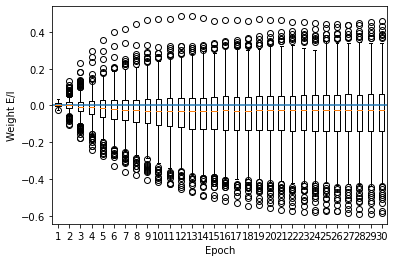

In [35]:

trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/saved/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        # '/tmp/saved/*3e1*/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

X = trace['rw']
X = X[:,~jnp.eye(X.shape[1], dtype=bool)]

plt.boxplot(X.T)
plt.axhline(0)
plt.xlabel('Epoch')
plt.ylabel('Weight E/I')
;

# YY

In [173]:
from io import StringIO


In [456]:
# 0 and Fixed Delays same param count
csv_data = '''0,1,2,3,4,5,6,7
neurons,10,15,20,25,30,45,60
nparams_0,70,105,140,175,210,315,420
nparams_inf,140,210,280,350,420,630,840
nparams_2d,104,149,194,239,284,419,554
nparams_3d,121,171,221,271,321,471,621
nparams_4d,138,193,248,303,358,523,688
t1p_0d,70.078125,68.535155,70.195315,71.40625,71.5625,81.45508000000001,79.71679499999999
t1p_fd,70.888675,80.29297,86.18163999999999,82.480465,81.2793,88.242185,90.6738275
t1p_inf,77.41211,82.421875,85.49805,86.93359,90.3125,90.634765,91.865235
t1p_2d,76.40625,78.515625,84.23828,85.283205,89.492185,90.75195,93.1445325
t1p_3d,68.99414,79.25781,80.99609,82.96875,88.22266,89.13086,90.4394525
t1p_4d,65.361328,74.56055,86.1132825,83.79883000000001,87.49023500000001,88.867185,90.839845
'''.strip()

df = pd.read_csv(StringIO(csv_data))
df = df.set_index('0', ).T
df

0,neurons,nparams_0,nparams_inf,nparams_2d,nparams_3d,nparams_4d,t1p_0d,t1p_fd,t1p_inf,t1p_2d,t1p_3d,t1p_4d
1,10.0,70.0,140.0,104.0,121.0,138.0,70.078125,70.888675,77.412110,76.406250,68.994140,65.361328
2,15.0,105.0,210.0,149.0,171.0,193.0,68.535155,80.292970,82.421875,78.515625,79.257810,74.560550
3,20.0,140.0,280.0,194.0,221.0,248.0,70.195315,86.181640,85.498050,84.238280,80.996090,86.113282
4,25.0,175.0,350.0,239.0,271.0,303.0,71.406250,82.480465,86.933590,85.283205,82.968750,83.798830
5,30.0,210.0,420.0,284.0,321.0,358.0,71.562500,81.279300,90.312500,89.492185,88.222660,87.490235
6,45.0,315.0,630.0,419.0,471.0,523.0,81.455080,88.242185,90.634765,90.751950,89.130860,88.867185
7,60.0,420.0,840.0,554.0,621.0,688.0,79.716795,90.673828,91.865235,93.144532,90.439453,90.839845


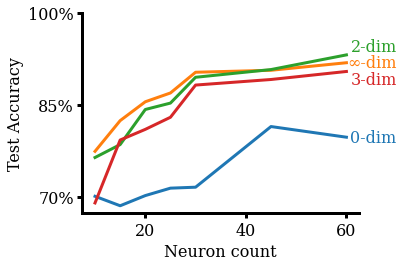

In [288]:

#plt.plot(df.neurons, df.t1p_fd)
label(plt.plot(df.neurons, df.t1p_0d),  '0-dim', ha='right', va='center', dx=10)
label(plt.plot(df.neurons, df.t1p_inf), '∞-dim', ha='right', va='center', dx=10)
label(plt.plot(df.neurons, df.t1p_2d),  '2-dim', ha='right', va='bottom', dx=10)
label(plt.plot(df.neurons, df.t1p_3d),  '3-dim', ha='right', va='top',    dx=10)
#plt.plot(df.neurons, df.t1p_4d)

plt.ylabel('Test Accuracy')
plt.yticks([70, 85, 100], [f'{x}%' for x in [70, 85, 100]])
plt.xlabel('Neuron count')

plt.tight_layout()
plt.savefig('img/yy0.png')
plt.savefig('img/yy0.svg')


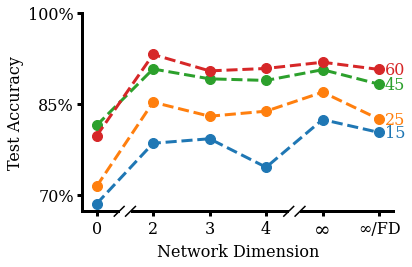

In [287]:
for nh in 15, 25, 45, 60:
    x = '0', '2', '3', '4', '∞', '∞/FD'
    y = df[['t1p_0d',  't1p_2d', 't1p_3d', 't1p_4d', 't1p_inf', 't1p_fd']][df.neurons == nh].values[0]
    line, = plt.plot(np.arange(len(x)), y, 'o--')
    plt.text(
        len(x)-1+.1,
        y[-1],
        f'{nh}',
        va='center',
        ha='left',
        color = line.get_color()
    )

ax = plt.gca()

ax.set_xticks(np.arange(len(x)))
text_labels = ax.set_xticklabels(x)
text_labels[-2].set_fontsize(20)
plt.ylabel('Test Accuracy')
plt.yticks([70, 85, 100], [f'{x}%' for x in [70, 85, 100]])

a = plt.ylim()

plt.gcf().canvas.draw()
y_data = ax.get_ylim()[0]

for x_positions in [
        [0.4, 0.6],
        [3.4, 3.6]
    ]:
    L_px = 15.0
    half = L_px / 2.0
    d = half / np.sqrt(2.0)
    to_display = ax.transData.transform
    to_data = ax.transData.inverted().transform
    to_display = ax.transData.transform
    to_data = ax.transData.inverted().transform
    ax.plot([min(x_positions)+0.03, -0.03+max(x_positions)], [y_data, y_data], color='w', linewidth=3, clip_on=False, zorder=10)
    for x0 in x_positions:
        x_disp, y_disp = to_display((x0, y_data))
        p1_disp = (x_disp - d, y_disp - d)
        p2_disp = (x_disp + d, y_disp + d)
        p1_data = to_data(p1_disp)
        p2_data = to_data(p2_disp)
        ax.plot([p1_data[0], p2_data[0]], [p1_data[1], p2_data[1]],
                color='k', linewidth=1.5, clip_on=False, zorder=100)

plt.ylim(a)
plt.xlabel('Network Dimension')

plt.tight_layout()
plt.savefig('img/yy1.png')
plt.savefig('img/yy1.svg')

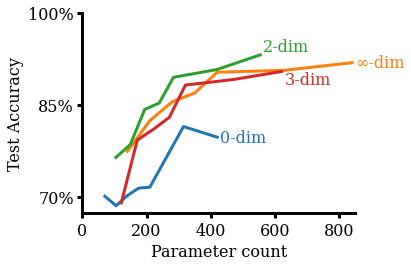

In [463]:
#spatial
#0	neurons	nparams_0	nparams_inf	nparams_2d	nparams_3d	nparams_4d	t1p_0d	t1p_fd	t1p_inf	t1p_2d	t1p_3d	t1p_4d


#plt.plot(df.neurons, df.t1p_fd)
label(plt.plot(df.nparams_0, df.t1p_0d),  '0-dim', ha='left', va='center', dx=10)
label(plt.plot(df.nparams_inf, df.t1p_inf), '∞-dim', ha='left', va='center', dx=10)
label(plt.plot(df.nparams_2d, df.t1p_2d),  '2-dim', ha='left', va='bottom', dx=10)
label(plt.plot(df.nparams_3d, df.t1p_3d),  '3-dim', ha='left', va='top',    dx=10)
#plt.plot(df.neurons, df.t1p_4d)

plt.ylabel('Test Accuracy')
plt.yticks([70, 85, 100], [f'{x}%' for x in [70, 85, 100]])
plt.xlabel('Parameter count')
plt.xlim(0, 850)

plt.tight_layout()
plt.savefig('img/yy0params.png')
plt.savefig('img/yy0params.svg')

# Grid

In [80]:
finaleps = (epoch[(epoch.i == 29) & (epoch.net.apply(lambda x: 'g' in x))]).copy()

finaleps['eps'] = finaleps['netspec'].str.split('g').str[1].astype(float)
finaleps = finaleps.loc[:, finaleps.nunique() > 1]
finaleps = finaleps.drop('netspec', axis='columns').drop('net', axis='columns').drop('id', axis='columns')
# print(finaleps.groupby(['nhidden', 'plotdim', 'eps']).count())
low = finaleps.groupby(['nhidden', 'eps']).quantile(0.5).reset_index().drop('seed', axis='columns')
high = finaleps.groupby(['nhidden', 'eps']).quantile(0.75).reset_index().drop('seed', axis='columns')
finaleps = finaleps.groupby(['nhidden', 'eps']).median().reset_index().drop('seed', axis='columns')
#finaleps = finaleps[finaleps.nhidden == 10].groupby('net').median().sort_values('netspec')

# 10, 30, 50
#for n in [10, 30, 50]:

# display(finaleps)

for n in [10, 30, 50, 300]:
    X =finaleps[finaleps.nhidden == n]
    L =low[low.nhidden == n]
    H =high[high.nhidden == n]
    label(line := plt.plot(
        100+100*X.eps,
        X.t1p,
        '-'),
        f'n={n}', dx=4)
    plt.fill_between(
        100+100*X.eps.values,
        L.t1p.values,
        H.t1p.values, alpha=0.3, zorder=-100)
    reference = finalnormal[(finalnormal.net == str(2)) &(finalnormal.nhidden == n)].t1p.median()
    plt.plot(
        [95, 100], 
        [reference, reference],
        ls='-',
        color=line[0].get_color(),
        zorder=100,
        clip_on=False
    )
        
ml = np.array([100, 125, 150])
plt.xticks(ml, [f'{x}%' for x in ml])

#plt.legend()
plt.ylabel('Test accuracy')
plt.xlabel('Max length w.r.t. straight line')

plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])

plt.xlim(100, 150)

plt.tight_layout()
plt.savefig('img/grid.svg')
plt.savefig('img/grid.png')

KeyError: "['netspec'] not found in axis"

In [393]:
epoch.net

0             2
1             2
2             2
3             2
4             2
          ...  
41236    2g0.30
41237    2g0.30
41238    2g0.30
41239    2g0.30
41240    2g0.30
Name: net, Length: 41241, dtype: object

# Remap it back

# Paths of a line

In [100]:

ident = '20251126_d2_h30_lr0.01_llNone_dt0.05_2ad67336-d388-4c2f-94af-2ada4f56c1d2'
trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/{ident}/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

In [104]:
x = trace['ipos'][:,:,0]
y = trace['ipos'][:,:,1]

xr = trace['rpos'][:,:,0]
yr = trace['rpos'][:,:,1]

print(x.shape)

(21, 700)


(21, 700)

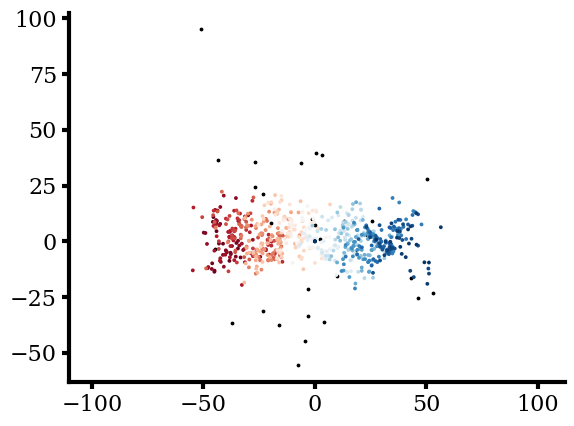

In [105]:
epoch = -1
plt.scatter(xr[epoch], yr[epoch], color='black', s=3)
plt.scatter(x[epoch], y[epoch], c=np.arange(700), s=3, cmap='RdBu')
plt.axis('equal')
x.shape

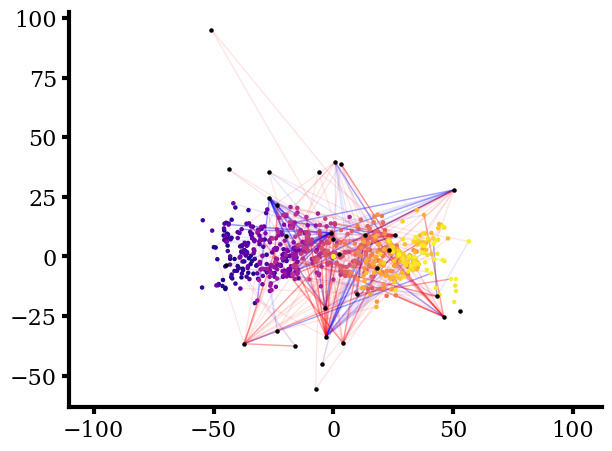

In [128]:
epoch = -1

w = trace['iw'][-1]
wr = trace['rw'][-1]

for ii, jj in zip(*np.where(w > 2)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.3)
for ii, jj in zip(*np.where(w < -2)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.3)
for ii, jj in zip(*np.where(w > 1.5)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.1)
for ii, jj in zip(*np.where(w < -1.5)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.1)
    
for ii, jj in zip(*np.where(wr > 2)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.3)
for ii, jj in zip(*np.where(wr < -2)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.3)
for ii, jj in zip(*np.where(wr > 1.5)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.1)
for ii, jj in zip(*np.where(wr < -1.5)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.1)
    
plt.scatter(x[epoch], y[epoch], c=np.arange(700), s=5, cmap='plasma', zorder=10)
plt.scatter(xr[epoch], yr[epoch], color='black', s=5, zorder=10)

plt.axis('equal')

plt.tight_layout()
plt.savefig('img/somat.svg')
plt.savefig('img/somat.png')

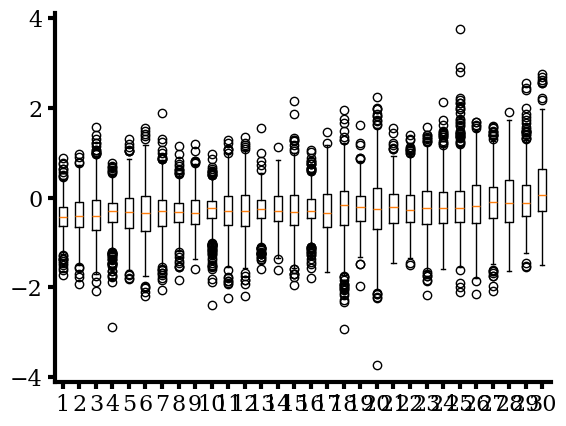

In [87]:
plt.boxplot(w[w.sum(1).argsort()].T);
#ww = [x[np.abs(x) > 2] for x in w]
#plt.boxplot(ww);

[15,
 23,
 5,
 5,
 4,
 3,
 3,
 2,
 2,
 2,
 2,
 3,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 1,
 6,
 14,
 11]

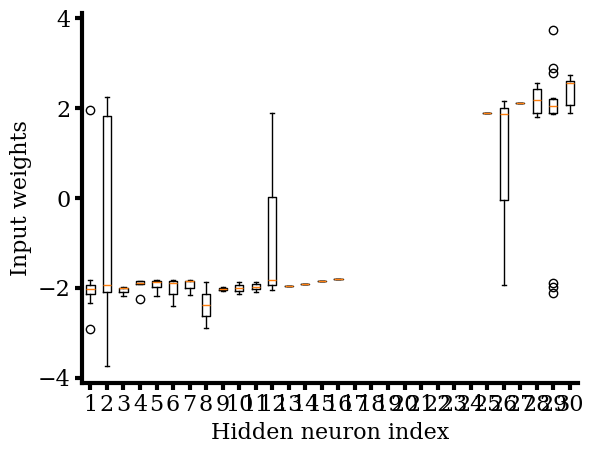

In [98]:
ww = sorted([x[np.abs(x) > 1.8] for x in w], key=lambda x: sum(x))
plt.boxplot(ww);
plt.ylabel('Input weights')
plt.xlabel('Hidden neuron index')
list(map(len, ww))

# sparse

In [63]:

x = dfs['sparse_epoch']
x[x.i==29]

,id,i,t1p,t3p,t1p_sp,t3p_sp,t1p_train,t3p_train,net,nhidden,...,possigma,tgtfreq,population_freq,tag,line,sparse,ninput,noutput,netspec,ndim
29,d4138fdd-78b7-439e-a414-c845e4673b91,29,77.285881,94.386574,76.461227,93.561928,96.153847,100.000000,3,300,...,20.0,10.0,False,sparse_dev,False,0.60,700,20,3,3
96,1948df4b-5ff7-43a7-af85-d6ef17bd92c6,29,74.609375,93.981483,76.750580,95.081024,94.831734,99.759613,3,300,...,20.0,10.0,False,sparse_dev,False,0.30,700,20,3,3
126,ebc0dbf9-f845-4568-bb7e-84bfa6cc4d12,29,74.638313,91.435188,76.287621,92.563660,96.243988,99.609375,3,300,...,20.0,10.0,False,sparse_dev,False,0.70,700,20,3,3
156,08dc559a-ba06-4257-b540-33f8f4168006,29,78.486687,92.954285,79.673035,93.851273,93.464546,100.000000,3,300,...,20.0,10.0,False,sparse_dev,False,0.50,700,20,3,3
186,ed26562d-46e3-4733-8c22-ec939b1071d5,29,76.634842,94.169563,76.750580,96.281830,85.486778,98.242188,3,300,...,20.0,10.0,False,sparse_dev,False,0.10,700,20,3,3
216,4c836f12-ae64-4c8a-8a2d-9f2e3b213247,29,77.054398,93.359375,77.575233,93.272568,97.806488,99.804688,3,300,...,20.0,10.0,False,sparse_dev,False,0.90,700,20,3,3
246,ff8f2a66-dbbe-49d8-a487-1dd1ef2bd238,29,75.245949,94.343178,74.623840,92.910881,92.142426,99.023438,3,300,...,20.0,10.0,False,sparse_dev,False,0.20,700,20,3,3
276,86c797cc-bd52-48b8-a937-3b1b57f8624e,29,65.957756,88.614006,26.851852,54.267941,67.833534,91.511421,3,300,...,20.0,10.0,False,sparse_dev,False,0.01,700,20,3,3
306,dc59f068-8c4c-4402-aa39-8426b0fa6770,29,75.477432,93.070023,76.779518,93.200233,95.612984,99.804688,3,300,...,20.0,10.0,False,sparse_dev,False,0.40,700,20,3,3


In [77]:
x = dfs['sparse_epoch']

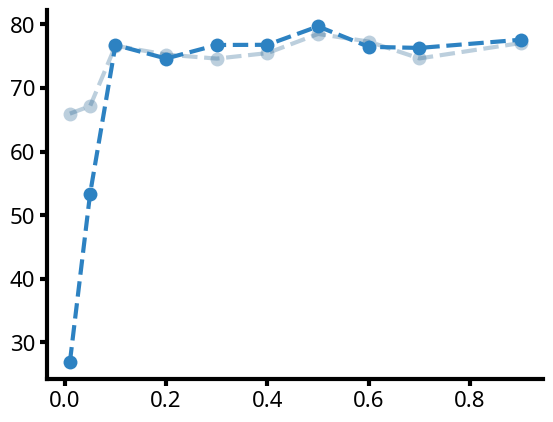

In [93]:
x = dfs['sparse_epoch']

if 0:
    x = x[x.i==29]
else:
    # while waiting for simulation finish
    x = x[((x.groupby('id').i.max()[x.id].values==x.i) & (x['sparse'] < 0.1)) | (x.i == 29)]

#display(x)

x = x.sort_values('sparse')
s = x['sparse']
t = x.t1p
plt.plot(s, t, 'o--', color='#1f5f8f4c', markeredgecolor='none')
ts = x.t1p_sp
plt.plot(s, ts, 'o--', color='#2d82c2ff', markeredgecolor='none')
#plt.ylim(60, 100)
#plt.xlim(0, 1)

plt.savefig('img/sparse_all.png')
plt.savefig('img/sparse_all.svg')

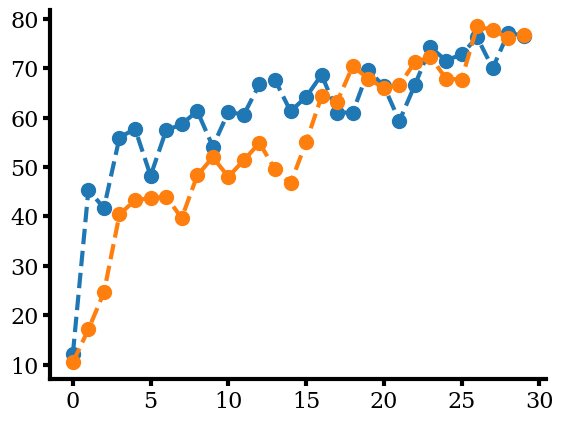

In [16]:
ident = 'ed26562d-46e3-4733-8c22-ec939b1071d5'

x = dfs['sparse_epoch']
x = x[x['id'] == ident]
plt.plot(x.i, x.t1p, 'o--')
plt.plot(x.i, x.t1p_sp, 'o--')

plt.savefig('img/sparse0.1_epochs.png')
plt.savefig('img/sparse0.1_epochs.svg')

In [ ]:
ident = '20251126_d2_h30_lr0.01_llNone_dt0.05_2ad67336-d388-4c2f-94af-2ada4f56c1d2'

ident = 'ed26562d-46e3-4733-8c22-ec939b1071d5'

trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/*{ident}*/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

In [46]:
ident = '20251114_d3_h250_lr0.001_llNone_dt0.5_98a6917b-a3a7-4f54-bafe-0b3654dfd5b1'

cmptrace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/*{ident}*/epoch_*.npz'
    ) if not 'read' in x)
]

cmpcolumns = cmptrace[0].keys()

cmptrace = {
    k: np.array([x[k] for x in cmptrace]) for k in cmpcolumns
}

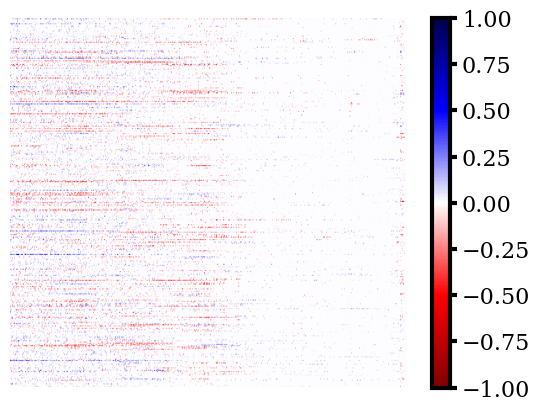

In [57]:

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(
    'custom',
    ['#c2452dff', 'white', '#2d82c2ff']
)

W = trace['iw'][-1]
#W = W[::4,::8]
#W = trace['rw'][-1]
lim = abs(W).max()
lim = 1
plt.imshow(W, aspect='auto', cmap='seismic_r', vmin=-lim, vmax=lim)
plt.colorbar()
plt.axis('off')
plt.savefig('img/spweights_iw_full.svg')

plt.figure()

#W = trace['iw'][-1]
W = trace['rw'][-1]
#W = W[::4,::4]
lim = abs(W).max()
lim = 1
plt.imshow(W, aspect='auto', cmap='seismic_r', vmin=-lim, vmax=lim)
plt.colorbar()
plt.axis('off')
plt.savefig('img/spweights_rw_full.svg')

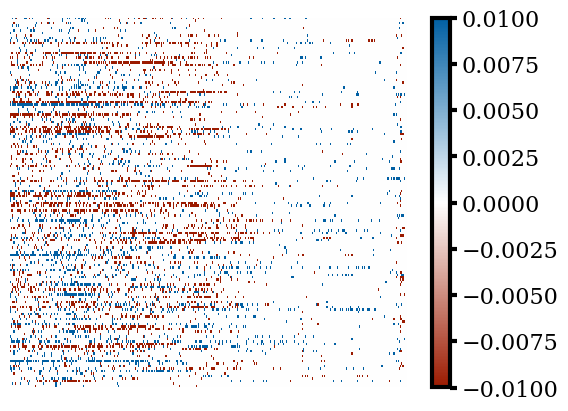

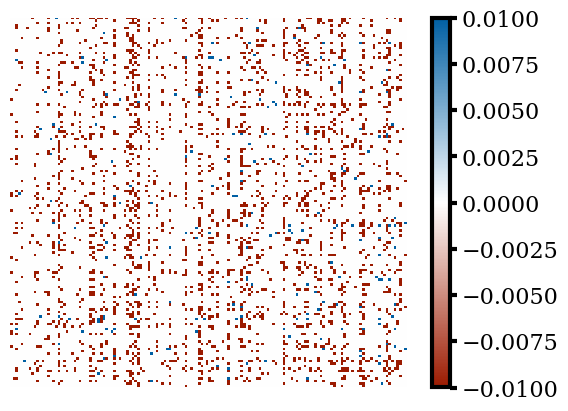

In [79]:
from matplotlib.colors import LinearSegmentedColormap


bottom = '#9b1a00ff'   # stronger red
mid    = 'white'
top    = '#005fa3ff'   # stronger blue

cmap = LinearSegmentedColormap.from_list(
    'custom_sat',
    [bottom, mid, top]
)

lim = max(abs(trace['iw'][::2]).max(), abs(trace['rw'][::2]).max())
lim = 0.01

W = trace['iw'][-1]
W = W[::2,::2]
plt.imshow(W, aspect='auto', cmap=cmap, vmin=-lim, vmax=lim, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.savefig('img/spweights_zoom.svg')

plt.figure()

#W = trace['iw'][-1]
W = trace['rw'][-1]
W = W[::2,::2]
plt.imshow(W, aspect='auto', cmap=cmap, vmin=-lim, vmax=lim, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.savefig('img/spweights_zoomrw.svg')

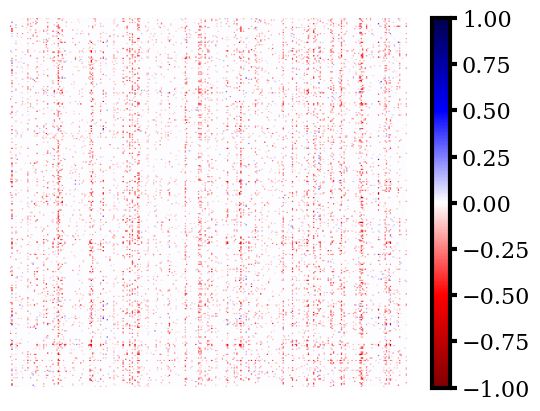

In [7]:
iw = trace['iw'][-1].flatten()
rw = trace['rw'][-1].flatten()
idel = spatial_to_delay(trace['rpos'][-1], trace['ipos'][-1])
rdel = spatial_to_delay(trace['rpos'][-1])

I1201 16:58:20.622550   10139 pjrt_api.cc:118] GetPjrtApi was found for cuda at /home/llandsmeer/.local/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so
I1201 16:58:20.622872   10139 pjrt_api.cc:96] PJRT_Api is set for device type cuda
W1201 16:58:20.624617   10139 debug_options_flags.cc:1081] "xla_cpu_use_thunk_runtime" is no longer supported and will be removed in a future release.
I1201 16:58:20.627244   10139 pjrt_client.cc:550] PjRt-IFRT device count: total=1, addressable=1
I1201 16:58:20.627252   10139 pjrt_client.cc:554] Addressable PjRt-IFRT device: CpuDevice(id=0)
I1201 16:58:20.627872   10139 pjrt_api.cc:167] The PJRT plugin has PJRT API version 0.80. The framework PJRT API version is 0.80.
I1201 16:58:20.759942   10139 service.cc:158] XLA service 0x35aeb290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I1201 16:58:20.759963   10139 service.cc:166]   StreamExecutor device (0): NVIDIA RTX PRO 6000 Blackwell Max-Q 

/tmp/ipykernel_10139/3755571902.py:2: RuntimeWarning: invalid value encountered in divide
  p = (W > 0).sum(0) / (W != 0).sum(0)


(0.0, 1.0)

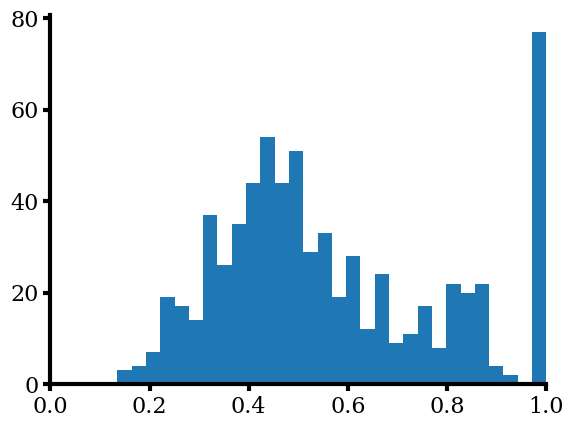

In [46]:
W = trace['iw'][-1]
p = (W > 0).sum(0) / (W != 0).sum(0)
plt.hist(p, bins=30)
plt.xlim(0, 1)


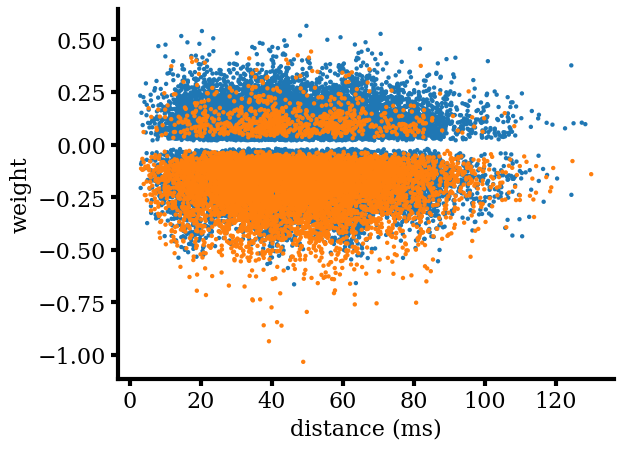

In [33]:
im = (iw != 0)
rm = (rw != 0)
plt.scatter(idel[im], iw[im], s=10, label='Input', edgecolor='none')
plt.scatter(rdel[rm], rw[rm], s=10, label='Recurrent', edgecolor='none')

plt.xlabel('distance (ms)')
plt.ylabel('weight')

#plt.legend()
plt.savefig('img/sparse0.1.svg')
plt.savefig('img/sparse0.1.png')

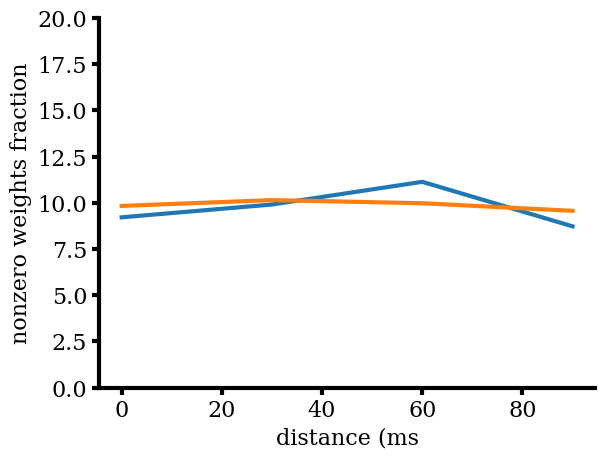

In [15]:

# last_epochs = [
#     dict(np.load(x))
#     for x in 
#     sorted(x for x in glob.glob(
#         # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
#         # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
#         f'saved/sparse*/epoch_00000029.npz'
#     ) if not 'read' in x)
# ]
# 



binsize = 30
o = []
for i in range(0, 120, binsize):
    m = (idel >= i) & (idel < i + binsize)
    mm = (rdel >= i) & (rdel < i + binsize)
    o.append(dict(
        i = i,
        ip = (iw[m] != 0).mean(),
        rp = (rw[mm] != 0).mean()
    ))

o = pd.DataFrame(o)
plt.plot(o.i, 100*o.ip)
plt.plot(o.i, 100*o.rp)

#plt.axhline(0.1)
plt.ylim([0, 20])

plt.xlabel('distance (ms')
plt.ylabel('nonzero weights fraction')

plt.savefig('img/sparse0.1_weights_fraction.svg')

[14.95411728  0.41777449 -6.04715443]
[19.14362472  2.95830318 -7.60846492]


([<matplotlib.axis.XTick at 0x72226ed68380>,
 [Text(1, 0, 'Dense I'),
  Text(2, 0, 'Sparse I'),
  Text(3, 0, 'Dense H'),
  Text(4, 0, 'Sparse H')])

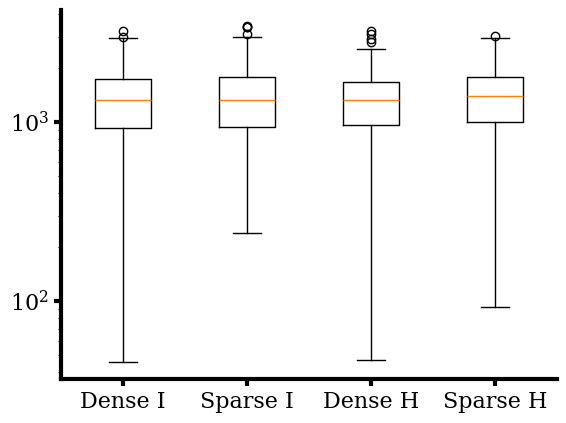

In [61]:
ipos = trace['ipos']
rpos = trace['rpos']

cipos = cmptrace['ipos']
crpos = cmptrace['rpos']


def dist(pos):
    diffs = np.diff(pos, axis=1)
    step = np.linalg.norm(diffs, axis=2)
    return step.sum(axis=0)
    

print(ipos[0][0])
print(ipos[-1][0])

#plt.hist(np.concatenate([ dist(crpos), dist(cipos) ]) , bins=30, density=True, alpha=0.5)
#plt.hist(np.concatenate([ dist(rpos), dist(ipos) ]), bins=30, density=True, alpha=0.5)

#plt.hist(np.concatenate([ dist(crpos) ]) , bins=30, density=True, alpha=0.5)
#plt.hist(np.concatenate([ dist(rpos) ]), bins=30, density=True, alpha=0.5)

plt.boxplot([
    dist(cipos),
    dist(ipos),
    dist(crpos),
    dist(rpos)
] )

;
plt.yscale('log')

plt.xticks([1,2,3,4],
           ['Dense I', 'Sparse I', 'Dense H', 'Sparse H'])

In [54]:
diffs = np.diff(rpos, axis=1)
diffs.shape
step = np.linalg.norm(diffs, axis=2)
print(step.shape)
step.sum(axis=1).shape

(30, 299)


(30,)

In [ ]:
epoch = -1

w = trace['iw'][-1]
wr = trace['rw'][-1]

x = trace['ipos'][:,:,0]
y = trace['ipos'][:,:,1]

xr = trace['rpos'][:,:,0]
yr = trace['rpos'][:,:,1]

print(x.shape)

print(1)
for ii, jj in zip(*np.where(w > 2)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.3)
print(1)
for ii, jj in zip(*np.where(w < -2)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.3)
print(1)
for ii, jj in zip(*np.where(w > 0)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.1)
print(1)
for ii, jj in zip(*np.where(w < 0)):
    plt.plot([ x[epoch, jj], xr[epoch, ii], ], [ y[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.1)
print(1)
    
for ii, jj in zip(*np.where(wr > 2)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.3)
print(1)
for ii, jj in zip(*np.where(wr < -2)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.3)
print(1)
for ii, jj in zip(*np.where(wr > 0)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='blue', lw=1, alpha=0.1)
print(1)
for ii, jj in zip(*np.where(wr < 0)):
    plt.plot([ xr[epoch, jj], xr[epoch, ii], ], [ yr[epoch, jj], yr[epoch, ii] ], color='red', lw=1, alpha=0.1)
print(1)
    
plt.scatter(x[epoch], y[epoch], c=np.arange(700), s=5, cmap='plasma', zorder=10)
print(1)
plt.scatter(xr[epoch], yr[epoch], color='black', s=5, zorder=10)
print(1)

plt.axis('equal')

plt.tight_layout()
#plt.savefig('img/sparsom.svg')
#plt.savefig('img/sparsom.png')

# 3d plot shd

In [92]:
ident = '20251113_d3_h30_lr0.001_llNone_dt0.5_d15a0edd-1cf0-431a-bcb0-e349b109368d'
trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/{ident}/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

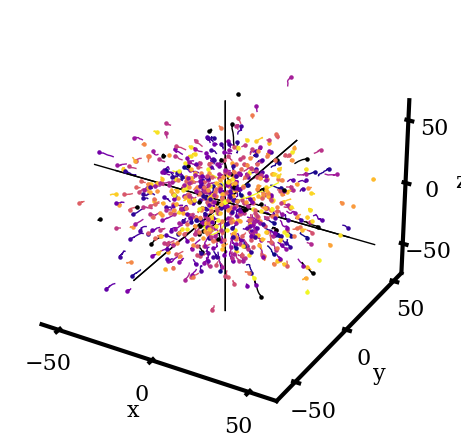

In [124]:

from mpl_toolkits.mplot3d import Axes3D  # sigh, still required

# trace['ipos'].shape # time, neuron, (x,y,z)
# trace['rpos'].shape # time, neuron, (x,y,z)

ipos = trace['ipos']
rpos = trace['rpos']

T, N, _3 = ipos.shape
cmap = plt.get_cmap('plasma')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', computed_zorder=True)

ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))



all_points = ipos.reshape(-1,3)
xlim = (all_points[:,0].min(), all_points[:,0].max())
ylim = (all_points[:,1].min(), all_points[:,1].max())
zlim = (all_points[:,2].min(), all_points[:,2].max())


def draw_plane(func, u_range, v_range, color='gray', alpha=0.5, steps=30):
    u_vals = np.linspace(u_range[0], u_range[1], steps)
    v_vals = np.linspace(v_range[0], v_range[1], steps)
    for i in range(steps-1):
        for j in range(steps-1):
            u0, u1 = u_vals[i], u_vals[i+1]
            v0, v1 = v_vals[j], v_vals[j+1]
            uu, vv = np.meshgrid([u0, u1], [v0, v1])
            xx, yy, zz = func(uu, vv)
            ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)

# x=0 plane
#draw_plane(lambda y,z: (np.zeros_like(y), y, z), ylim, zlim)

# y=0 plane
#draw_plane(lambda x,z: (x, np.zeros_like(x), z), xlim, zlim)

# z=0 plane
#draw_plane(lambda x,y: (x, y, np.zeros_like(x)), xlim, ylim)

for i in range(N):
    p = ipos[:, i]
    c = cmap(i / (N - 1)) if N > 1 else cmap(0)
    ax.plot(p[:,0], p[:,1], p[:,2], color=c, linewidth=1)
    ax.scatter(p[-1,0], p[-1,1], p[-1,2], color=c, s=5)
    
T, N, _3 = rpos.shape
for i in range(N):
    p = rpos[:, i]
    ax.plot(p[:,0], p[:,1], p[:,2], color='black', linewidth=1)
    ax.scatter(p[-1,0], p[-1,1], p[-1,2], color='black', s=5)


ax.grid(False)


# draw planes at x=0, y=0, z=0

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

a = 1.2

ax.plot([0,0], [a*ylim[0], a*ylim[1]], [0,0], color='k', linewidth=1)  # along y
ax.plot([0,0], [0,0], [a*zlim[0], a*zlim[1]], color='k', linewidth=1)  # along z

# y=0 line along x and z
ax.plot([a*xlim[0], a*xlim[1]], [0,0], [0,0], color='k', linewidth=1)  # along x
ax.plot([0,0], [0,0], [a*zlim[0], a*zlim[1]], color='k', linewidth=1)  # along z

# z=0 line along x and y
ax.plot([xlim[0], xlim[1]], [0,0], [0,0], color='k', linewidth=1)  # along x
ax.plot([0,0], [a*ylim[0], a*ylim[1]], [0,0], color='k', linewidth=1)  # along y

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_xticks([-50, 0, 50])
ax.set_yticks([-50, 0, 50])
ax.set_zticks([-50, 0, 50])

fig.savefig('img/3dshd.svg')

plt.tight_layout()
plt.show()

# New results

In [6]:
!ls saved | grep 20251202

20251202_d0_h300_lr0.001_llNone_dt0.5_0ac9f30e-9eae-44a9-80bf-d5eae0b2e0a4
20251202_d2_h300_lr0.001_llNone_dt0.5_8d6a325b-007c-4153-bee9-0ca59a1ea451
20251202_d3_h300_lr0.001_llNone_dt0.5_60a91ecd-ba81-4ec7-9d11-a2314ed8c9c7
20251202_dinf_h300_lr0.001_llNone_dt0.5_8b99594b-1be6-45d5-ac71-b2ce88b6edbc
20251202_dinf_h300_lr0.001_llNone_dt0.5_bab14453-6133-4e0b-a1f9-cd1ff9fffdb3
adex_20251202_d3_h100_lr0.001_llNone_dt0.5_52034ef7-696a-4e08-a617-2c98f4624e02
adex_20251202_d3_h100_lr0.001_llNone_dt0.5_a84a445f-9a93-49e2-a55c-56e1f4837198
adex_20251202_d3_h10_lr0.001_llNone_dt0.5_126ec515-f6d4-4d92-9308-101b3706f430
adex_20251202_d3_h10_lr0.001_llNone_dt0.5_98b06d44-c765-4569-9261-084e9b92fbe8
adex_20251202_d3_h300_lr0.001_llNone_dt0.5_2a3ba080-f76f-4ac9-ad59-eb61c45bd72a
adex_20251202_d3_h300_lr0.001_llNone_dt0.5_bf90c64e-1ade-4e32-b228-cce8ee0c611b
adex_20251202_d3_h30_lr0.001_llNone_dt0.5_0600f456-e291-483d-a20f-51e4c8e2b6e9
adex_20251202_d3_h30_lr0.001_llNone_dt0.5_0ce26bee-b62f-4fe0-acc

## Mapping it 

In [7]:
ident = '20251202_dinf_h300_lr0.001_llNone_dt0.5_8b99594b-1be6-45d5-ac71-b2ce88b6edbc'
trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/{ident}/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

In [22]:
idel = trace['idelay'][-1].reshape(300, 700)
rdel = trace['rdelay'][-1].reshape(300, 300)

rdel = rdel * (1-np.eye(len(rdel)))



In [64]:
        
import numpy as np
from scipy.optimize import minimize

ndims = [1,2,3,4,5,6,7,8,9,10]
rs = []
for ndim in tqdm.tqdm(ndims):
    def pairwise_dist(x, N):
        x = x.reshape(N, ndim)
        diff = x[:, None, :] - x[None, :, :]
        return np.linalg.norm(diff, axis=-1)

    def loss(x, rdel, N):
        D = pairwise_dist(x, N)
        return np.sum((D - rdel)**2)
    iters = 10
    N = rdel.shape[0]
    x0 = np.random.normal(size=(N, ndim)).ravel()
    res = minimize(loss, x0, args=(rdel, N), method='L-BFGS-B', options={'maxiter': iters})
    r = res.x.reshape(N, ndim)
    rs.append(r)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:29<00:00, 38.97s/it]


21.114037306128647
20.920171423916806
22.56882947638637
20.81425066108235
20.691128655519645
21.37459164168082
21.075447801498157
21.14778666017037
20.80522727518337
20.631084394923498


findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: 

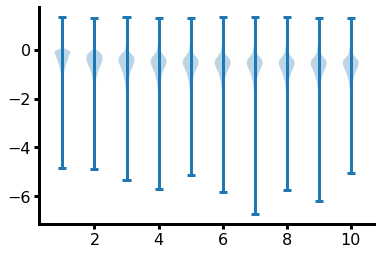

findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.


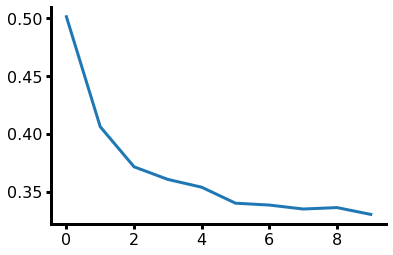

In [73]:
es = []
ees = []
for n, r in zip(ndims, rs):
    ndim = n
    e = np.abs(((pairwise_dist(r, len(rdel)) - rdel) / (rdel + np.eye(len(rdel))) * (1-np.eye(len(rdel)))))
    e = e[~np.eye(e.shape[0], dtype=bool)].ravel()
    print(e.max())
    ee = np.log10(e)
    es.append(e)
    ees.append(ee)

plt.violinplot(ees);
plt.figure()
plt.plot([e.mean() for e in es]);

(array([1.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00, 8.0000e+00,
        4.0000e+00, 9.0000e+00, 2.5000e+01, 3.9000e+01, 7.3000e+01,
        1.0800e+02, 1.9700e+02, 3.0600e+02, 5.0500e+02, 8.0800e+02,
        1.4100e+03, 2.2030e+03, 3.7750e+03, 6.1670e+03, 9.7620e+03,
        1.5101e+04, 2.0364e+04, 1.8338e+04, 6.8980e+03, 2.2090e+03,
        9.7800e+02, 3.3200e+02, 6.0000e+01, 1.3000e+01, 2.0000e+00]),
 array([-5.18307972, -4.96557971, -4.74807971, -4.53057971, -4.31307971,
        -4.09557971, -3.87807971, -3.66057971, -3.44307971, -3.2255797 ,
        -3.0080797 , -2.7905797 , -2.5730797 , -2.3555797 , -2.1380797 ,
        -1.9205797 , -1.7030797 , -1.4855797 , -1.26807969, -1.05057969,
        -0.83307969, -0.61557969, -0.39807969, -0.18057969,  0.03692031,
         0.25442031,  0.47192032,  0.68942032,  0.90692032,  1.12442032,
         1.34192032]),
 <BarContainer object of 30 artists>)

findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: Font family 'Noto sans' not found.
findfont: 

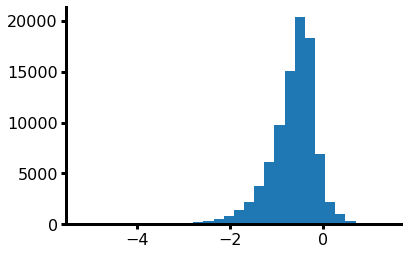